# CropAI_Training_Notebook
This script trains a MobileNetV2-based deep learning model to classify crop diseases using leaf images. It uses TensorFlow and Keras for model building, with support for training visualization and model checkpointing.


## Imports
Loads all the necessary libraries: TensorFlow, Keras, NumPy, Matplotlib, shutil, os.

In [4]:
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


## Configuration & Setup
Defines image size, batch size, number of epochs, data paths

In [6]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
EPOCHS = 20
TRAIN_RATIO = 0.8

DATA_DIR = 'data/raw'
PROCESSED_DIR = 'data/processed'
TRAIN_DIR = os.path.join(PROCESSED_DIR, 'train')
VAL_DIR = os.path.join(PROCESSED_DIR, 'val')
MODEL_PATH = 'src/model/checkpoints/mobilenetv2_cropai.h5'
PLOT_PATH = 'assets/training_outputs/training_plot.png'

Path('src/model/checkpoints').mkdir(parents=True, exist_ok=True)
Path('assets/training_outputs').mkdir(parents=True, exist_ok=True)


## Dataset Split Function


In [8]:
def split_dataset(source_dir, output_dir, train_ratio=0.8):
    class_dirs = [d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))]

    for class_name in class_dirs:
        src_path = os.path.join(source_dir, class_name)
        images = [f for f in os.listdir(src_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        random.shuffle(images)

        train_count = int(len(images) * train_ratio)
        train_images = images[:train_count]
        val_images = images[train_count:]

        train_class_dir = os.path.join(output_dir, 'train', class_name)
        val_class_dir = os.path.join(output_dir, 'val', class_name)
        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(val_class_dir, exist_ok=True)

        for img in train_images:
            shutil.copy2(os.path.join(src_path, img), os.path.join(train_class_dir, img))
        for img in val_images:
            shutil.copy2(os.path.join(src_path, img), os.path.join(val_class_dir, img))

        print(f"Class '{class_name}': {len(train_images)} train, {len(val_images)} val")


In [9]:
if os.path.exists(PROCESSED_DIR):
    shutil.rmtree(PROCESSED_DIR)
os.makedirs(PROCESSED_DIR, exist_ok=True)

for crop in ['maize', 'tomato', 'beans']:
    crop_raw = os.path.join(DATA_DIR, crop)
    crop_out = os.path.join(PROCESSED_DIR)
    split_dataset(crop_raw, crop_out, TRAIN_RATIO)


Class 'healthy': 929 train, 233 val
Class 'rust': 1044 train, 262 val
Class 'leaf_blight': 916 train, 230 val
Class 'gray_leaf_spot': 459 train, 115 val
Class 'healthy': 1272 train, 319 val
Class 'early_blight': 800 train, 200 val
Class 'mosaic_virus': 298 train, 75 val
Class 'bacterial_spot': 1701 train, 426 val
Class 'healthy': 264 train, 66 val
Class 'angular_leaf_spot': 264 train, 66 val
Class 'bean_rust': 264 train, 66 val


## Prepare Data Loaders

In [11]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Found 8211 images belonging to 9 classes.
Found 2058 images belonging to 9 classes.


## Build and Compile Model

In [13]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,423,113 (9.24 MB)

 Trainable params: 165,129 (645.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Setup Callbacks

In [15]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint(MODEL_PATH, monitor='val_accuracy', save_best_only=True)


## Train the Model


In [17]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[early_stop, checkpoint]
)


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7934 - loss: 0.5929

257/257 ━━━━━━━━━━━━━━━━━━━━ 649s 2s/step - accuracy: 0.7936 - loss: 0.5920 - val_accuracy: 0.9135 - val_loss: 0.2440
Epoch 2/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9262 - loss: 0.2008

257/257 ━━━━━━━━━━━━━━━━━━━━ 655s 3s/step - accuracy: 0.9262 - loss: 0.2008 - val_accuracy: 0.9305 - val_loss: 0.1792
Epoch 3/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 540s 2s/step - accuracy: 0.9494 - loss: 0.1424 - val_accuracy: 0.9295 - val_loss: 0.1912
Epoch 4/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9525 - loss: 0.1297

257/257 ━━━━━━━━━━━━━━━━━━━━ 653s 3s/step - accuracy: 0.9525 - loss: 0.1297 - val_accuracy: 0.9354 - val_loss: 0.1657
Epoch 5/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 582s 2s/step - accuracy: 0.9618 - loss: 0.1075 - val_accuracy: 0.9344 - val_loss: 0.1644
Epoch 6/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 592s 2s/step - accuracy: 0.9637 - loss: 0.1001 - val_accuracy: 0.9300 - val_loss: 0.1874
Epoch 7/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 556s 2s/step - accuracy: 0.9621 - loss: 0.1042 - val_accuracy: 0.9320 - val_loss: 0.1693
Epoch 8/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9614 - loss: 0.1013

257/257 ━━━━━━━━━━━━━━━━━━━━ 525s 2s/step - accuracy: 0.9614 - loss: 0.1013 - val_accuracy: 0.9412 - val_loss: 0.1495
Epoch 9/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9707 - loss: 0.0812

257/257 ━━━━━━━━━━━━━━━━━━━━ 550s 2s/step - accuracy: 0.9707 - loss: 0.0812 - val_accuracy: 0.9470 - val_loss: 0.1441
Epoch 10/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 502s 2s/step - accuracy: 0.9686 - loss: 0.0778 - val_accuracy: 0.9354 - val_loss: 0.1770
Epoch 11/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 520s 2s/step - accuracy: 0.9670 - loss: 0.0870 - val_accuracy: 0.9363 - val_loss: 0.1668
Epoch 12/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 605s 2s/step - accuracy: 0.9653 - loss: 0.0873 - val_accuracy: 0.9388 - val_loss: 0.1700


## Plot Accuracy

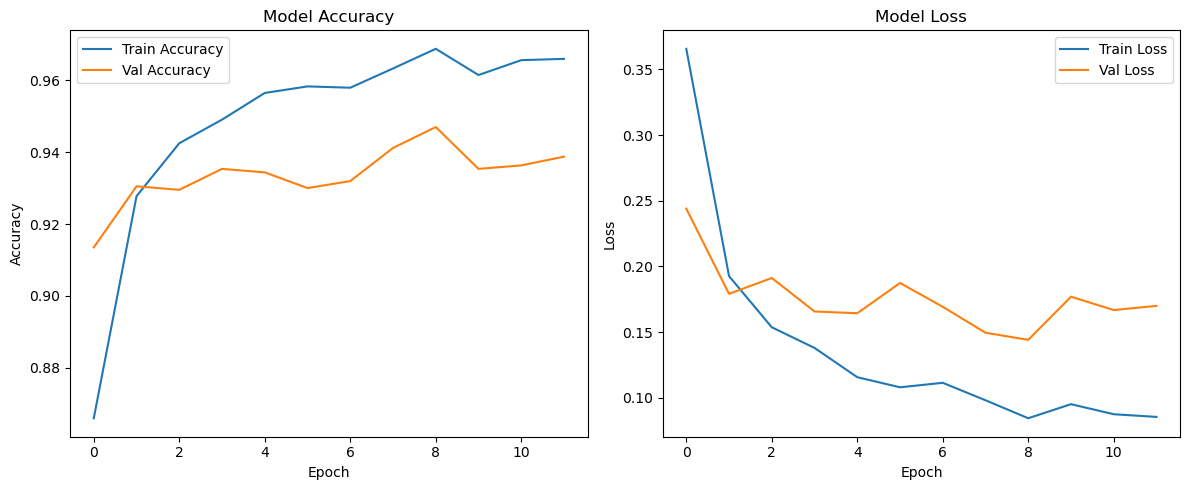

In [30]:
# Plot accuracy and loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy plot
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Val Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Loss plot
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Val Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

# Save and show
plot_path = "assets/training_outputs/training_plots.png"
plt.tight_layout()
plt.savefig(plot_path)
plt.show()
